# Pedestrian Detection using SVM and HOG

In [1]:
# 📦 Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report
import time
import glob
from tqdm import tqdm


## 1. Load image paths and assign labels

In [2]:
# Define the path to the images with and without pedestrians
path_with_pedestrians = "bdd_people/with_people/train/*.jpg"
path_without_pedestrians = "bdd_people/without_people/train/*.jpg"

# Load up to 800 images per class, this bacause with all the image take more time
images_with_people = glob.glob(path_with_pedestrians)[:1500]
images_without_people = glob.glob(path_without_pedestrians)[:1500]

# Combine all image paths and labels
all_images = images_with_people + images_without_people
all_labels = [1] * len(images_with_people) + [0] * len(images_without_people)  # 1 = pedestrian, 0 = no pedestrian

print(f"🔍 Images with pedestrians: {len(images_with_people)}")
print(f"🔍 Images without pedestrians: {len(images_without_people)}")

🔍 Images with pedestrians: 1500
🔍 Images without pedestrians: 1500


## 2. Split image paths into train/test

In [3]:
# Use 80% of the data for training and 20% for testing
x_train_paths, x_test_paths, y_train_raw, y_test_raw = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

## 3. Extract HOG features from images

In [4]:
# Function to extract HOG features from an image path
def extract_hog(image_path, size=(128, 128)):
    """
    Extract HOG features from an image.

    Parameters:
        image_path (str): Path to the image.
        size (tuple): Resize dimensions before feature extraction. (128, 64) is standard for pedestrian detection.

    Returns:
        features (ndarray): 1D array of HOG features.
    """
    image = imread(image_path)           # Load image
    gray_image = rgb2gray(image)         # Convert to grayscale
    resized_image = resize(gray_image, size)  # Resize to standard shape

    # 128x64 is the reference size for human detection based on Dalal & Triggs' original HOG paper.
    # Ensures alignment with common HOG block/cell sizes and optimal feature representation.
    features = hog(resized_image,
                   orientations=9,              # Number of gradient orientation bins (common choice is 9 for 0–180 degrees)
                   pixels_per_cell=(8, 8),      # Size of the cell in pixels where gradient histograms are computed
                   cells_per_block=(2, 2),      # Block is made of 2x2 cells; this helps normalize across local contrast
                   block_norm='L2-Hys',         # L2-Hys normalization improves contrast invariance (used in original paper)
                   visualize=False)             # No need for visualization here — we only want the features

    return features

# Extract HOG features from all images in train/test sets
X_train = np.array([extract_hog(path) for path in tqdm(x_train_paths, desc="🔨 Extracting HOG (Train)", disable=False)])
X_test = np.array([extract_hog(path) for path in tqdm(x_test_paths, desc="🔍 Extracting HOG (Test)", disable=False)])

# Convert labels to NumPy arrays
y_train = np.array(y_train_raw)
y_test = np.array(y_test_raw)


🔨 Extracting HOG (Train): 100%|█████████████████████████████████| 2400/2400 [03:57<00:00, 10.09it/s]
🔍 Extracting HOG (Test): 100


## 4. Visualize HOG features of example images

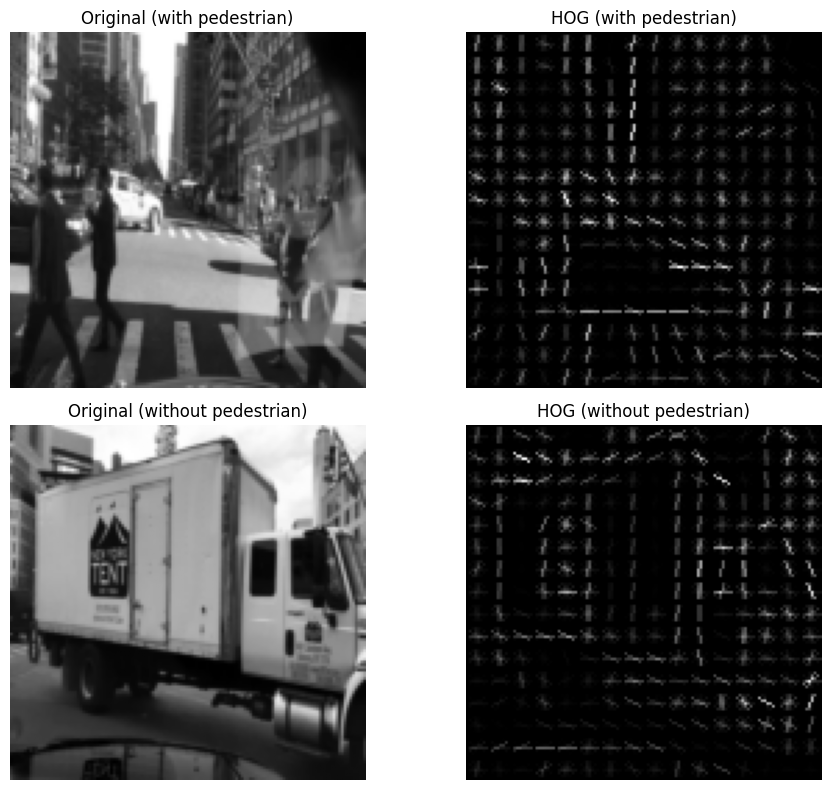

In [5]:
# Function to return both the grayscale and HOG image
def visualize_hog(image_path):
    # Load image in grayscale directly
    image = imread(image_path, as_gray=True)

    # Resize to (128, 64) which is the standard detection window for pedestrians (used in training too)
    image = resize(image, (128, 128))

    # Compute HOG features and also return the visualization image
    _, hog_image = hog(image,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys',
                       visualize=True)

    return image, hog_image

# Visualize one pedestrian and one non-pedestrian example
example_with = images_with_people[0]
example_without = images_without_people[0]
img1, hog1 = visualize_hog(example_with)
img2, hog2 = visualize_hog(example_without)

# Display the original and HOG-transformed images
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(img1, cmap='gray'); axs[0, 0].set_title("Original (with pedestrian)")
axs[0, 1].imshow(hog1, cmap='gray'); axs[0, 1].set_title("HOG (with pedestrian)")
axs[1, 0].imshow(img2, cmap='gray'); axs[1, 0].set_title("Original (without pedestrian)")
axs[1, 1].imshow(hog2, cmap='gray'); axs[1, 1].set_title("HOG (without pedestrian)")
for ax in axs.ravel(): ax.axis('off')
plt.tight_layout(); plt.show()

## 5. Train an SVM model using GridSearchCV (SVC)

In [ ]:
# Define a grid of hyperparameters to search over

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1, 10], # Kernel coefficient for RBF
    'kernel': ['rbf'] # Use RBF kernel
}

# Perform grid search with cross-validation
print("🔧 Searching for best hyperparameters...")
grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

🔧 Searching for best hyperparameters...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


## 6. Display the best model configuration (SVC)

In [ ]:
best_model = grid_search.best_estimator_
print("✅ Best Params (SVC):", grid_search.best_params_)

## 5.1 Train an SVM model using GridSearchCV (Linear SVC)

In [ ]:
# Create pipeline: scaling + LinearSVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(dual=False, max_iter=10000))
])

# Grid search for best regularization value C
param_grid_linear = {
    'linear_svc__C': [0.01, 0.1, 1, 10, 100]
}

print("🔧 Searching for best hyperparameters (LinearSVC)...")
grid_search_linear = GridSearchCV(pipeline, param_grid_linear, cv=5, verbose=1, n_jobs=-1)
grid_search_linear.fit(X_train, y_train)


## 6.1 Display the best model configuration (SVC)

In [ ]:
best_linear_model = grid_search_linear.best_estimator_
print("✅ Best Params (LinearSVC):", grid_search_linear.best_params_)

## 7. Evaluate and Select the Best Model

In [ ]:
# --- Evaluate RBF SVC ---
start = time.time()
y_pred_rbf = best_model.predict(X_test)
end = time.time()
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"📈 RBF SVC Accuracy: {acc_rbf:.4f} - Inference Time: {end - start:.2f}s")

# --- Evaluate LinearSVC ---
start = time.time()
y_pred_linear = best_linear_model.predict(X_test)
end = time.time()
acc_linear = accuracy_score(y_test, y_pred_linear)
print(f"📈 LinearSVC Accuracy: {acc_linear:.4f} - Inference Time: {end - start:.2f}s")

# --- Select Best Model ---
if acc_rbf >= acc_linear:
    final_model = best_model
    y_pred = y_pred_rbf
    print("✅ Selected model: RBF SVC")
else:
    final_model = best_linear_model
    y_pred = y_pred_linear
    print("✅ Selected model: Linear SVC")

## 8. Display the best model configuration

In [ ]:
# Predict the test set labels
y_pred = best_model.predict(X_test)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Display classification metrics
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Define readable class names
class_names = ['No pedestrian', 'Pedestrian']

## 9. Visualize predictions on test images

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = imread(x_test_paths[i])
    image = resize(image, (128, 128))
    plt.imshow(image, cmap='gray')

    predicted_label = int(y_pred[i])
    true_label = int(y_test_raw[i])
    color = 'green' if predicted_label == true_label else 'red'
    plt.xlabel(f"{class_names[predicted_label]} ({class_names[true_label]})", color=color)

plt.tight_layout()
plt.show()